<a href="https://colab.research.google.com/github/julicaon/Chemoinformatics_ML/blob/main/logBB(classification).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Генерация и отбор признаков**

In [1]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 13.2 MB/s eta 0:00:00


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict
from rdkit import Chem
from rdkit.Chem import Crippen, Descriptors, GraphDescriptors, Lipinski, QED, rdMolDescriptors
from tqdm import tqdm

sns.set_theme()

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [66]:
df_full = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/data/data.csv', header=0)

for i in df_full["SMILES"]:
  df_full["SMILES"].replace(i, Chem.CanonSmiles(i), inplace=True)

df_full.drop_duplicates(subset = 'SMILES', keep = 'first', inplace=True)

df = df_full["SMILES"]

df = {'SMILES': df}

df = pd.DataFrame(df)

list_inorg_el = ['Al', 'Au', 'Ar,''Ba', 'Be', 'Bi', 'Ca','Cd', 'Co','Cr','Cu','Fe', 'Gd','Ge', 'Hf',
                 'Hg', 'In', 'K', 'Kr' 'La', 'Mg', 'Mn', 'Na', 'Ni', 'Pb', 'Pt', 'Sb', 'Sn','Sr','Te',
                 'V','Zn', 'Li', 'Xe', 'Rn', 'Ne']
index_drop = []
uniq_el = set([])

sm = df['SMILES'].values
index_sm = df.index.tolist()

for sm_i in range(len(sm)):
    mol_sm = Chem.MolFromSmiles(sm[sm_i])
    list_at = [str(x.GetSymbol()) for x in mol_sm.GetAtoms()]
    intersec = list(set(list_at) & set(list_inorg_el))
    T_C = 'C' in list_at
    if T_C == False:
        index_drop.append(index_sm[sm_i])
    elif len(intersec) > 0 or sm[sm_i] == 'O=C=O' or sm[sm_i] == '[C-]#[O+]': # убираем CO2 или CO
        index_drop.append(index_sm[sm_i])
    uniq_el = uniq_el | set(list_at)

df.drop(index=index_drop, inplace=True)

df_PUBCHEM = pd.DataFrame(df)
df_AVALON = pd.DataFrame(df)
df_ECFP6 = pd.DataFrame(df)

df

,SMILES
0,O=C(O)c1cc(N=Nc2ccc(S(=O)(=O)Nc3ccccn3)cc2)ccc1O
1,COC1(NC(=O)C(C(=O)O)c2ccc(O)cc2)C(=O)N2C(C(=O)...
2,Oc1c(I)cc(Cl)c2cccnc12
3,CCNC(=NCCSCc1ncccc1Br)NC#N
4,CN1CC[C@]23c4c5ccc(OC6O[C@H](C(=O)O)[C@@H](O)[...
...,...
7791,c1ccc(CN(CC2=NCCN2)c2ccccc2)cc1
7792,CCOCCn1c(N2CCCN(C)CC2)nc2ccccc21
7793,CN1CCC(=C2c3ccccc3CC(=O)c3sccc32)CC1
7794,Cc1[nH]c(=O)c(C#N)cc1-c1ccncc1


 ### **▶ Физико-химические свойства**




In [46]:
df_QED = pd.DataFrame(df)

for i, row in df_QED.iterrows():
    mol = Chem.MolFromSmiles(row.SMILES)
    qed_vector = QED.properties(mol)
    '''Масса молекулы'''
    df_QED.at[i, 'MW'] = round(qed_vector[0], 2)
    '''Строго говоря, это коэффициент, который показывает отношение концентрации вещества в октаноле
    к отношении концентрации вещества в воде. Оказалось, что играет огромную роль в фармакологии: чем выше
    значение logP, тем лучше вещество показывает себя в качестве лекарства '''
    df_QED.at[i, 'AlogP'] = round(qed_vector[1], 2)
    df_QED.at[i, 'MlogP'] = round(Crippen.MolLogP(mol), 2)
    '''Число атомов, оттягивающих на себя электронную плотность при образовании водородных связей (например, N, O)'''
    df_QED.at[i, '#HBA'] = qed_vector[2]
    '''Число атомов и  групп, "отдающих" электронную плотность при образовании водородных связей'''
    df_QED.at[i, '#HBD'] = qed_vector[3]
    '''Cумма площадей поверхности всех полярных атомов в молекуле. ОЧЕНЬ важный дескриптор в задачах медицинской химии:
       чем меньше значение TPSA, тем лучше молекула проходит через различные барьеры в нашем организме'''
    df_QED.at[i, 'PSA'] = qed_vector[4]
    '''Число связей, которые могут свободно вращаться вокруг своей оси связи, не сталкиваясь со значительными пространственными препятствиями'''
    df_QED.at[i, '#ROTB'] = qed_vector[5]

    df_QED.at[i, 'MaxPartialCharge'] = round(Descriptors.MaxPartialCharge(mol), 2)
    df_QED.at[i, 'MinPartialCharge'] = round(Descriptors.MinPartialCharge(mol), 2)

    df_QED.at[i, '#AromaticCarbocycles'] = Lipinski.NumAromaticCarbocycles(mol)
    df_QED.at[i, '#AromaticHeterocycles'] = Lipinski.NumAromaticHeterocycles(mol)
    '''Число атомов, отличных от углерода и водорода'''
    df_QED.at[i, '#Heteroatoms'] = Lipinski.NumHeteroatoms(mol)

df_QED = pd.merge(df_full, df_QED, how= 'left', on= 'SMILES')
df_QED.head()

,SMILES,Activity,MW,AlogP,MlogP,#HBA,#HBD,PSA,#ROTB,MaxPartialCharge,MinPartialCharge,#AromaticCarbocycles,#AromaticHeterocycles,#Heteroatoms
0,O=C(O)c1cc(N=Nc2ccc(S(=O)(=O)Nc3ccccn3)cc2)ccc1O,0,398.40,3.70,3.70,6.0,3.0,141.31,6.0,0.34,-0.51,2.0,1.0,10.0
1,COC1(NC(=O)C(C(=O)O)c2ccc(O)cc2)C(=O)N2C(C(=O)...,0,520.48,-1.13,-1.13,13.0,4.0,206.30,9.0,0.35,-0.51,1.0,1.0,16.0
2,Oc1c(I)cc(Cl)c2cccnc12,0,305.50,3.20,3.20,2.0,1.0,33.12,0.0,0.15,-0.50,1.0,1.0,4.0
3,CCNC(=NCCSCc1ncccc1Br)NC#N,0,342.27,2.11,2.11,5.0,2.0,73.10,6.0,0.20,-0.36,0.0,1.0,7.0
4,CN1CC[C@]23c4c5ccc(OC6O[C@H](C(=O)O)[C@@H](O)[...,0,461.47,-1.24,-1.24,10.0,5.0,149.15,3.0,0.34,-0.48,1.0,0.0,10.0


<Axes: xlabel='MW', ylabel='Count'>

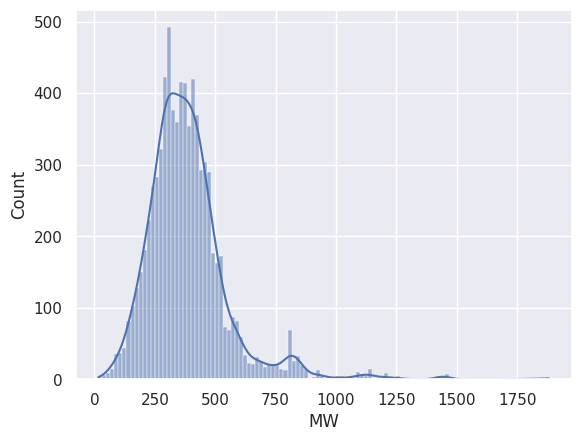

In [9]:
sns.histplot(df_QED['MW'], kde=True)

<Axes: xlabel='AlogP', ylabel='Count'>

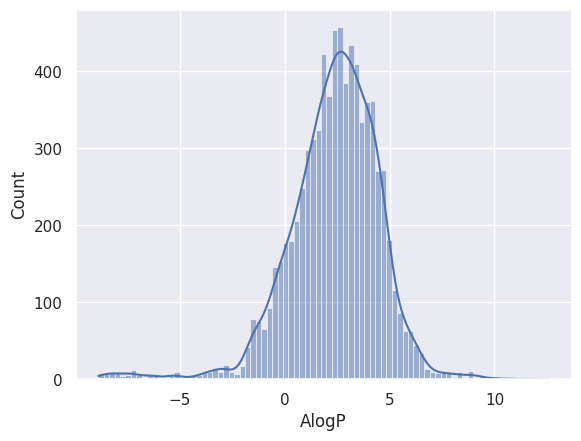

In [10]:
sns.histplot(df_QED['AlogP'], kde=True)

<Axes: xlabel='MlogP', ylabel='Count'>

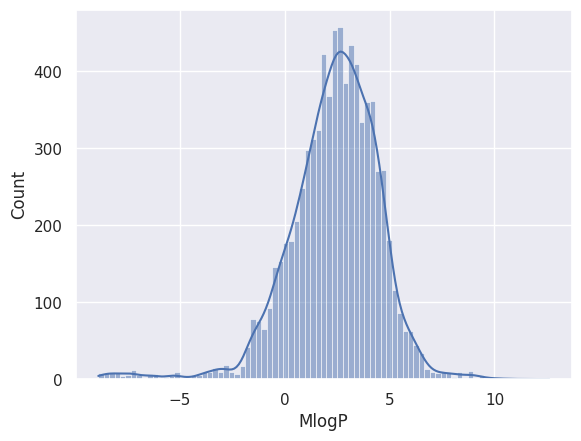

In [11]:
sns.histplot(df_QED['MlogP'], kde=True)

<Axes: xlabel='#HBA', ylabel='Count'>

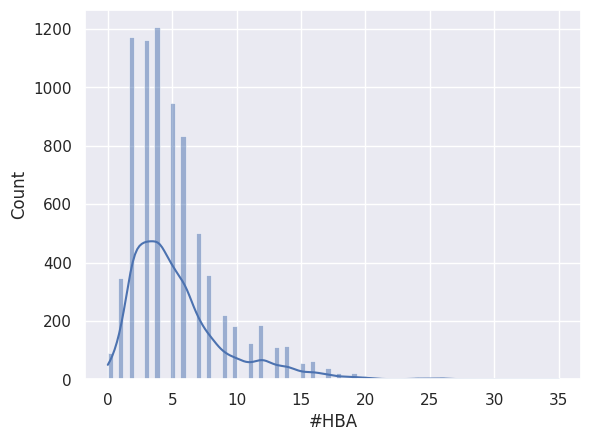

In [12]:
sns.histplot(df_QED['#HBA'], kde=True)

In [53]:
df_col = df_QED.columns.values.tolist()
df_col.remove("SMILES")

<Axes: >

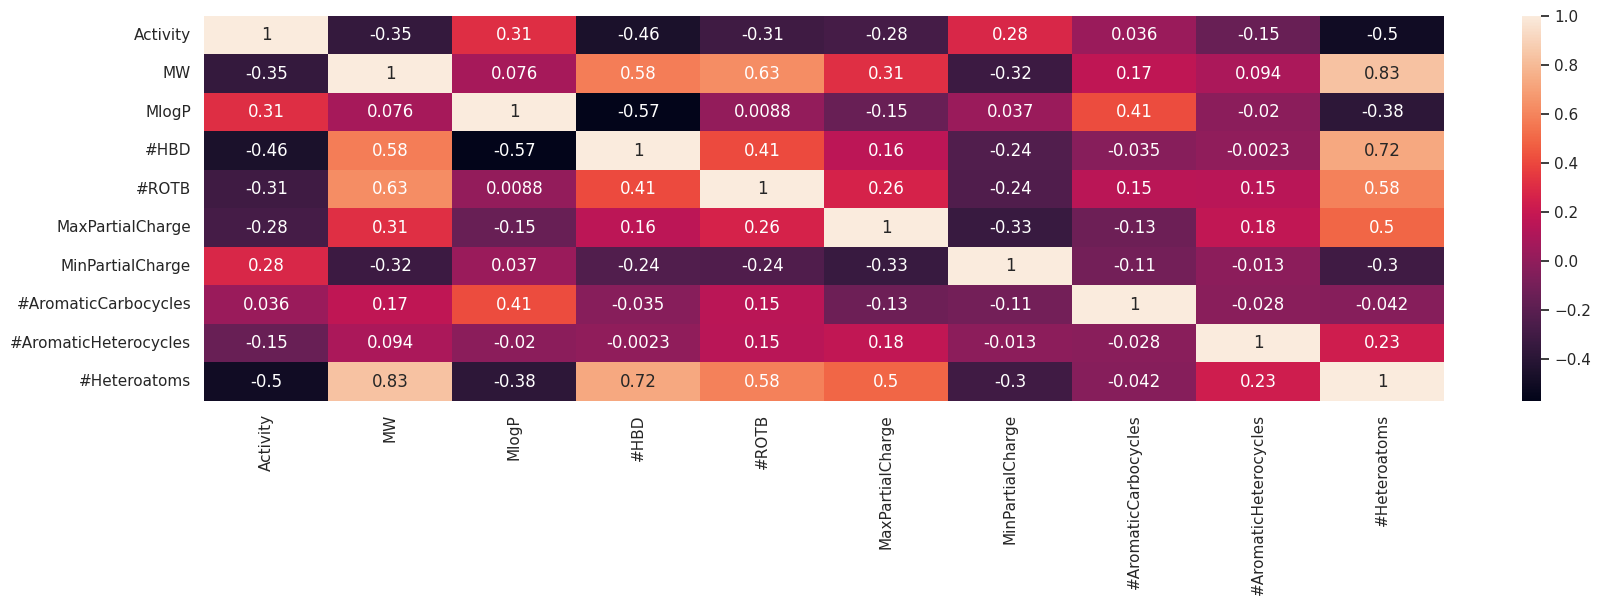

In [54]:
df_to_heatmap = df_QED[df_col]

corr_matrix = df_to_heatmap.corr()
col_index_to_del = []

for i in range(corr_matrix.shape[0]):
    for j in range(i):
        if abs(round(corr_matrix.iloc[i][j], 2)) >= 0.9 or abs(round(corr_matrix.iloc[i][j], 2)) == 1:
              if corr_matrix.iloc[i][0] >= corr_matrix.iloc[j][0]:
                col_index_to_del.append(j)
              else:
                col_index_to_del.append(i)

col_index_to_del = list(set(col_index_to_del))
col_index_to_del = [i + 1 for i in col_index_to_del]

df_QED.drop(df_QED.columns[col_index_to_del], axis=1, inplace=True)


#specify size of heatmap
fig, ax = plt.subplots(figsize=(20, 5))

sns.heatmap(df_to_heatmap.corr(), annot=True)

 ### **▶ Графовые дескрипторы** (основаны на представлении молекул в виде графов)







In [35]:
df_GD = pd.DataFrame(df)

for i, row in df_GD.iterrows():
    mol = Chem.MolFromSmiles(row.SMILES)
    df_GD.at[i, 'BalabanJ'] = round(GraphDescriptors.BalabanJ(mol), 2)
    df_GD.at[i, 'BertzCT'] = round(GraphDescriptors.BertzCT(mol), 2)
    '''Среднее значение коэффициентов характеристического многочлена матрицы смежности молекулярного графа'''
    df_GD.at[i, 'AvgIpc'] = round(GraphDescriptors.AvgIpc(mol), 2)
    df_GD.at[i, 'Ipc'] = round(GraphDescriptors.Ipc(mol), 2)
    df_GD.at[i, 'HallKierAlpha'] = round(GraphDescriptors.HallKierAlpha(mol), 2)
    df_GD.at[i, 'Kappa1'] = round(GraphDescriptors.Kappa1(mol), 2)
    df_GD.at[i, 'Kappa2'] = round(GraphDescriptors.Kappa2(mol), 2)
    df_GD.at[i, 'Kappa3'] = round(GraphDescriptors.Kappa3(mol), 2)

df_GD = pd.merge(df_full, df_GD, how= 'left', on= 'SMILES')
df_GD.head()

,SMILES,Activity,BalabanJ,BertzCT,AvgIpc,Ipc,HallKierAlpha,Kappa1,Kappa2,Kappa3
0,O=C(O)c1cc(N=Nc2ccc(S(=O)(=O)Nc3ccccn3)cc2)ccc1O,0,1.77,1130.40,2.68,1798099.97,-3.79,18.99,7.84,4.48
1,COC1(NC(=O)C(C(=O)O)c2ccc(O)cc2)C(=O)N2C(C(=O)...,0,1.58,1262.62,3.25,88447430.27,-4.02,25.08,9.56,4.14
2,Oc1c(I)cc(Cl)c2cccnc12,0,2.97,472.37,2.15,1131.07,-0.55,9.02,3.31,1.46
3,CCNC(=NCCSCc1ncccc1Br)NC#N,0,2.29,457.68,2.41,18476.88,-1.26,15.80,9.64,6.45
4,CN1CC[C@]23c4c5ccc(OC6O[C@H](C(=O)O)[C@@H](O)[...,0,1.41,1029.43,3.14,40710661.00,-2.21,21.33,7.14,2.73


<Axes: >

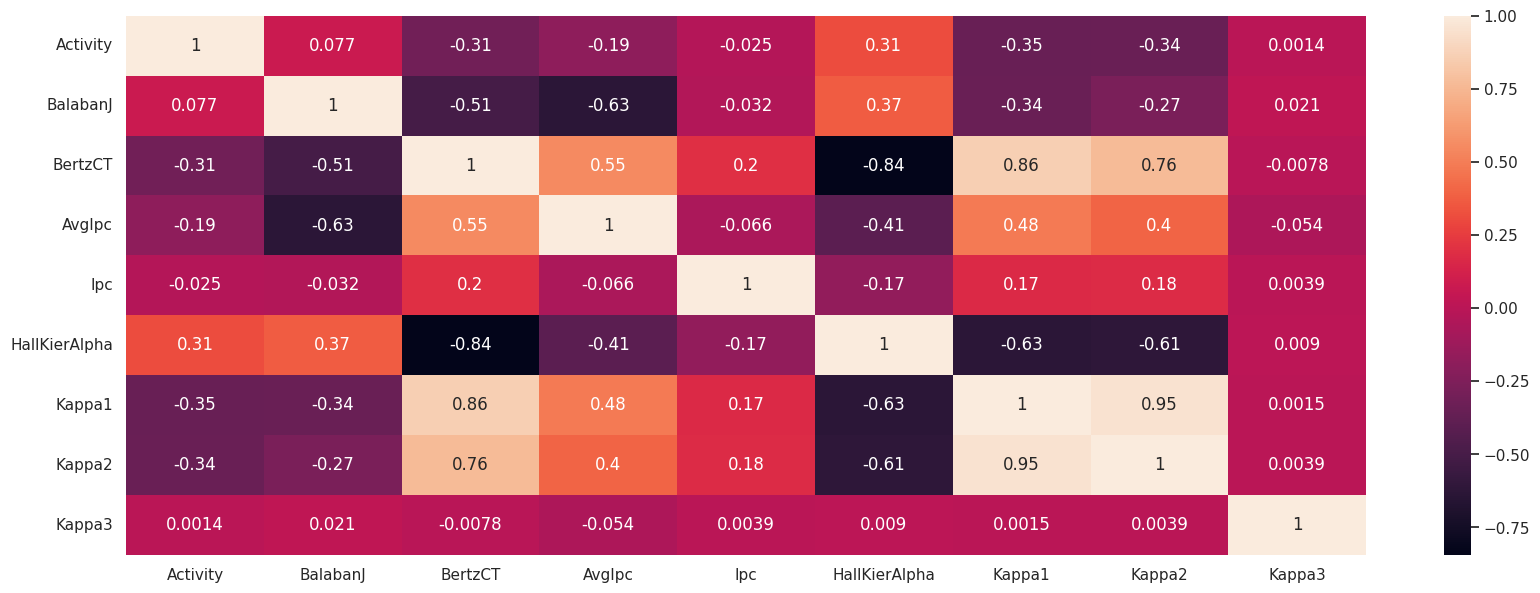

In [40]:
df_col = df_GD.columns.values.tolist()
df_col.remove("SMILES")

df_to_heatmap = df_GD[df_col]

col_index_to_del = []

for i in range(corr_matrix.shape[0]):
    for j in range(i):
        if abs(round(corr_matrix.iloc[i][j], 2)) >= 0.9:
              if corr_matrix.iloc[i][0] >= corr_matrix.iloc[j][0]:
                col_index_to_del.append(j)
              else:
                col_index_to_del.append(i)

col_index_to_del = list(set(col_index_to_del))
col_index_to_del = [i + 1 for i in col_index_to_del]

df_GD.drop(df_GD.columns[col_index_to_del], axis=1)

#specify size of heatmap
fig, ax = plt.subplots(figsize=(20, 7))

sns.heatmap(df_to_heatmap.corr(), annot=True)

### **MACCS keys**

In [ ]:
from rdkit.Chem import MACCSkeys

In [ ]:
def generate_MACCS(data):
    MACCS_keys = []
    mols = [Chem.MolFromSmiles(x) for x in data if x is not None]
    for mol in tqdm(mols):
        maccs = list(MACCSkeys.GenMACCSKeys(mol).ToBitString())
        MACCS_keys.append(maccs)
    return np.array(MACCS_keys)

In [ ]:
MACCS_keys = generate_MACCS(df['SMILES'])

100%|██████████| 7796/7796 [00:13<00:00, 581.94it/s]


In [ ]:
for i, row in df.iterrows():
    for j in range(MACCS_keys.shape[1]):
        df.at[i, f'MAC_{j+1}'] =  MACCS_keys[i][j]

df.head()

,SMILES,MAC_1,MAC_2,MAC_3,MAC_4,MAC_5,MAC_6,MAC_7,MAC_8,MAC_9,...,MAC_158,MAC_159,MAC_160,MAC_161,MAC_162,MAC_163,MAC_164,MAC_165,MAC_166,MAC_167
0,O=C(O)c1cc(N=Nc2ccc(S(=O)(=O)Nc3ccccn3)cc2)ccc1O,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,1,1,1,1,0
1,COC1(NC(=O)C(C(=O)O)c2ccc(O)cc2)C(=O)N2C(C(=O)...,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,1,0
2,Oc1c(I)cc(Cl)c2cccnc12,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,1,1,1,1,0
3,CCNC(=NCCSCc1ncccc1Br)NC#N,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,1,1,0,1,0
4,CN1CC[C@]23c4c5ccc(OC6O[C@H](C(=O)O)[C@@H](O)[...,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0


### **Avalon fingerprints**

In [ ]:
from rdkit.Avalon import pyAvalonTools

In [ ]:
def generate_AVfpts(data):
    Avalon_fpts = []
    mols = [Chem.MolFromSmiles(x) for x in data if x is not None]
    '''Число бит можно регулировать. Обычно используется 512 или 1024'''
    for mol in tqdm(mols):
        avfpts = pyAvalonTools.GetAvalonFP(mol, nBits=512)
        Avalon_fpts.append(avfpts)
    return np.array(Avalon_fpts)

In [ ]:
Avalon_fpts = generate_AVfpts(df['SMILES'])

100%|██████████| 7796/7796 [00:11<00:00, 651.42it/s]


In [ ]:
Avalon_fpts.shape

(7796, 512)

In [ ]:
for i, row in df_AVALON.iterrows():
    for j in range(Avalon_fpts.shape[1]):
        df_AVALON.at[i, f'A_{j+1}'] = Avalon_fpts[i][j]

df_AVALON.head()

,SMILES,A_1,A_2,A_3,A_4,A_5,A_6,A_7,A_8,A_9,...,A_503,A_504,A_505,A_506,A_507,A_508,A_509,A_510,A_511,A_512
0,O=C(O)c1cc(N=Nc2ccc(S(=O)(=O)Nc3ccccn3)cc2)ccc1O,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,COC1(NC(=O)C(C(=O)O)c2ccc(O)cc2)C(=O)N2C(C(=O)...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
2,Oc1c(I)cc(Cl)c2cccnc12,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CCNC(=NCCSCc1ncccc1Br)NC#N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CN1CC[C@]23c4c5ccc(OC6O[C@H](C(=O)O)[C@@H](O)[...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Итоговый датафрейм для обычения: физ-хим дискрипторы + отпечатки пальцев Avalon

In [ ]:
df_rdkit_avalon = pd.merge(df_AVALON, df_QED, how= 'left', on= 'SMILES')
df_for_learn1 = pd.merge(df_full, df_rdkit_avalon, how= 'right', on= 'SMILES')
del df_for_learn1['SMILES']
df_for_learn1 = df_for_learn1.loc[df_for_learn1['Activity']. isin([0, 1])]

df_for_learn1.head()

,Activity,A_1,A_2,A_3,A_4,A_5,A_6,A_7,A_8,A_9,...,MlogP,#HBA,#HBD,PSA,#ROTB,MaxPartialCharge,MinPartialCharge,#AromaticCarbocycles,#AromaticHeterocycles,#Heteroatoms
0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.70,6.0,3.0,141.31,6.0,0.34,-0.51,2.0,1.0,10.0
1,0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-1.13,13.0,4.0,206.30,9.0,0.35,-0.51,1.0,1.0,16.0
2,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,3.20,2.0,1.0,33.12,0.0,0.15,-0.50,1.0,1.0,4.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.11,5.0,2.0,73.10,6.0,0.20,-0.36,0.0,1.0,7.0
4,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-1.24,10.0,5.0,149.15,3.0,0.34,-0.48,1.0,0.0,10.0


### **ECFP6 fingerprints** (Extended Connectivity Fingerprint with diameter 6)

При выделении фрагментов учитывается не только ближайшее окружение атома, но и его соседи, находящиеся на расстоянии до 3-ех химических связей

In [ ]:
def generate_ECFP6(data):
    ECFP6_fpts = []
    mols = [Chem.MolFromSmiles(x) for x in data if x is not None]
    for mol in tqdm(mols):
        ecfp6 = Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, 3)
        ECFP6_fpts.append(ecfp6)
    return np.array(ECFP6_fpts)

In [ ]:
ECFP6_fpts = generate_ECFP6(df['SMILES'])

100%|██████████| 7796/7796 [00:01<00:00, 5153.48it/s]


In [ ]:
for i, row in df_ECFP6.iterrows():
    for j in range(ECFP6_fpts.shape[1]):
        df_ECFP6.at[i, f'ECFP6_{j+1}'] =  ECFP6_fpts[i][j]
df_ECFP6.head()

,SMILES,ECFP6_1,ECFP6_2,ECFP6_3,ECFP6_4,ECFP6_5,ECFP6_6,ECFP6_7,ECFP6_8,ECFP6_9,...,ECFP6_2039,ECFP6_2040,ECFP6_2041,ECFP6_2042,ECFP6_2043,ECFP6_2044,ECFP6_2045,ECFP6_2046,ECFP6_2047,ECFP6_2048
0,O=C(O)c1cc(N=Nc2ccc(S(=O)(=O)Nc3ccccn3)cc2)ccc1O,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,COC1(NC(=O)C(C(=O)O)c2ccc(O)cc2)C(=O)N2C(C(=O)...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Oc1c(I)cc(Cl)c2cccnc12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CCNC(=NCCSCc1ncccc1Br)NC#N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CN1CC[C@]23c4c5ccc(OC6O[C@H](C(=O)O)[C@@H](O)[...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Итоговый датафрейм для обычения: физ-хим дискрипторы + отпечатки пальцев ECFP6

In [ ]:
df_rdkit_ECFP6 = pd.merge(df_ECFP6, df_QED, how= 'left', on= 'SMILES')
df_for_learn2 = pd.merge(df_full, df_rdkit_ECFP6, how= 'right', on= 'SMILES')
del df_for_learn2['SMILES']
df_for_learn2 = df_for_learn2.loc[df_for_learn2['Activity']. isin([0, 1])]
df_for_learn2.head()

,Activity,ECFP6_1,ECFP6_2,ECFP6_3,ECFP6_4,ECFP6_5,ECFP6_6,ECFP6_7,ECFP6_8,ECFP6_9,...,MlogP,#HBA,#HBD,PSA,#ROTB,MaxPartialCharge,MinPartialCharge,#AromaticCarbocycles,#AromaticHeterocycles,#Heteroatoms
0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,3.70,6.0,3.0,141.31,6.0,0.34,-0.51,2.0,1.0,10.0
1,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.13,13.0,4.0,206.30,9.0,0.35,-0.51,1.0,1.0,16.0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.20,2.0,1.0,33.12,0.0,0.15,-0.50,1.0,1.0,4.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.11,5.0,2.0,73.10,6.0,0.20,-0.36,0.0,1.0,7.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.24,10.0,5.0,149.15,3.0,0.34,-0.48,1.0,0.0,10.0


### **PubChem**

Основаны на данных, хранящихся в базе PubChem. Содержат как количественные физико-химические дескрипторы, так и фингерпринты

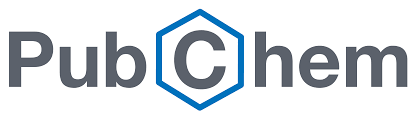

In [ ]:
!pip install pubchempy

  Preparing metadata (setup.py) ... done
  Created wheel for pubchempy: filename=PubChemPy-1.0.4-py3-none-any.whl size=13820 sha256=8b0a44752e9f806a34bf580bcc7a8a5b4b2f1ad02507161bdfcf63cfb319c8d1
  Stored in directory: /root/.cache/pip/wheels/90/7c/45/18a0671e3c3316966ef7ed9ad2b3f3300a7e41d3421a44e799
Successfully built pubchempy


In [ ]:
from pubchempy import *

In [ ]:
def generate_pubchem(data):
    rows_to_del = []
    pubchem_features = []
    idx = 0
    for smi in tqdm(list(data)):
        try:
            cid = get_cids(smi, 'smiles')[0]
            if cid == 0:
                rows_to_del.append(idx)
            else:
                features_dict = Compound.from_cid(cid).to_dict()
                descriptors = [features_dict['atom_stereo_count'], features_dict['bond_stereo_count'],
                               features_dict['complexity'], features_dict['covalent_unit_count'],
                               features_dict['isotope_atom_count']
                              ]
                fingerprints = [int(fp) for fp in list(features_dict['cactvs_fingerprint'])]
                pubchem_features.append(descriptors + fingerprints)
        except:
            rows_to_del.append(idx)
        idx = idx + 1
    return np.array(pubchem_features), rows_to_del

In [ ]:
pubchem_features, rows_to_del = generate_pubchem(df['SMILES'])

In [ ]:
for i in rows_to_del:
    df_PUBCHEM = df.drop(labels=[i], axis=0)

In [ ]:
pubchem_features.shape

In [ ]:
number = 0
for i, row in df_PUBCHEM.iterrows():
    for j in range(pubchem_features.shape[1]):
        df_PUBCHEM.at[number, f'PUBCHEM_{j+1}'] = pubchem_features[number][j]
    number = number + 1
df_PUBCHEM.head()

In [ ]:
df_PUBCHEM.reset_index(drop=True, inplace=True) # обновим индексы строк


In [ ]:
df_PUBCHEM.info()





# Обучение

 ### **Логистическая регрессия**


In [ ]:
import pandas as pd

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler

In [ ]:
df1 = df_for_learn1
df2 = df_for_learn2

split = KFold(n_splits=5, random_state=41, shuffle=True)
scores= {
         "F1":  make_scorer(f1_score),
         "AUC": make_scorer(roc_auc_score, needs_threshold=True) # roc_auc и f1 должны быть близки к 1
         }
df1.Activity.unique()

array([0, 1])

In [ ]:
X1 = df1.iloc[:, 1:].values
y1 = df1.iloc[:, 0].values

X2 = df2.iloc[:, 1:].values
y2 = df2.iloc[:, 0].values

In [ ]:
scaler = StandardScaler().fit(X1) # нормализация данных, приведение к нормальному распределению
X1 = scaler.transform(X1)

scaler = StandardScaler().fit(X2) # нормализация данных, приведение к нормальному распределению
X2 = scaler.transform(X2)

In [ ]:
class_model = LogisticRegression(random_state=42)

In [ ]:
parameters = {
    'penalty': [None, 'l2', 'l1', 'elasticnet'],
    'C': [0.1, 0.5, 1, 2, 5, 10],
    'class_weight': [None, 'balanced']
}

In [ ]:
roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True,
                             needs_threshold=True)

In [ ]:
grid_search = GridSearchCV(
    estimator=class_model,
    param_grid=parameters,
    scoring=roc_auc_scorer,
    verbose=3)

In [ ]:
grid_search.fit(X1, y1)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END C=0.1, class_weight=None, penalty=None;, score=0.848 total time=   0.5s
[CV 2/5] END C=0.1, class_weight=None, penalty=None;, score=0.893 total time=   0.5s
[CV 3/5] END C=0.1, class_weight=None, penalty=None;, score=0.911 total time=   0.5s
[CV 4/5] END C=0.1, class_weight=None, penalty=None;, score=0.825 total time=   0.5s
[CV 5/5] END C=0.1, class_weight=None, penalty=None;, score=0.936 total time=   0.5s
[CV 1/5] END C=0.1, class_weight=None, penalty=l2;, score=0.857 total time=   0.5s
[CV 2/5] END C=0.1, class_weight=None, penalty=l2;, score=0.897 total time=   0.5s
[CV 3/5] END C=0.1, class_weight=None, penalty=l2;, score=0.916 total time=   0.7s
[CV 4/5] END C=0.1, class_weight=None, penalty=l2;, score=0.833 total time=   0.8s
[CV 5/5] END C=0.1, class_weight=None, penalty=l2;, score=0.940 total time=   1.0s
[CV 1/5] END C=0.1, class_weight=None, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END C=0.

GridSearchCV(estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.1, 0.5, 1, 2, 5, 10],
                         'class_weight': [None, 'balanced'],
                         'penalty': [None, 'l2', 'l1', 'elasticnet']},
             scoring=make_scorer(roc_auc_score, needs_threshold=True),
             verbose=3)

In [ ]:
grid_search.best_params_

{'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2'}

In [ ]:
best_class_model1 = LogisticRegression(C = 0.1, class_weight='balanced', penalty = 'l2', random_state=42)

In [ ]:
cv_scores = cross_validate(best_class_model1, X1, y1, scoring=scores, cv=split)
print(f"On cross-validation:")
print(f"Mean ROC_AUC score is {cv_scores['test_AUC'].mean().round(3)} ± {cv_scores['test_AUC'].std().round(3)}")
print(f"Mean F1 score is {cv_scores['test_F1'].mean().round(3)} ± {cv_scores['test_F1'].std().round(3)}")

On cross-validation:
Mean ROC_AUC score is 0.916 ± 0.004
Mean F1 score is 0.874 ± 0.008


In [ ]:
best_class_model1.fit(X1, y1)

y_pred1 = best_class_model1.predict(X1)
print(f'Метки: {y_pred1}')
print(f"F1: {f1_score(y1, y_pred1).round(3)}")

y_pred1 = best_class_model1.predict_proba(X1)
print(f'Вероятности классов: {y_pred1}')
print(f"ROC_AUC: {roc_auc_score(y1, y_pred1[:, 1]).round(3)}")

Метки: [0 0 0 ... 1 1 0]
F1: 0.904
Вероятности классов: [[0.99072568 0.00927432]
 [0.995462   0.004538  ]
 [0.63823031 0.36176969]
 ...
 [0.09145901 0.90854099]
 [0.48902826 0.51097174]
 [0.81184479 0.18815521]]
ROC_AUC: 0.953


In [ ]:
grid_search.fit(X2, y2)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END C=0.1, class_weight=None, penalty=None;, score=0.843 total time=   2.0s
[CV 2/5] END C=0.1, class_weight=None, penalty=None;, score=0.870 total time=   2.0s
[CV 3/5] END C=0.1, class_weight=None, penalty=None;, score=0.886 total time=   1.9s
[CV 4/5] END C=0.1, class_weight=None, penalty=None;, score=0.801 total time=   1.9s
[CV 5/5] END C=0.1, class_weight=None, penalty=None;, score=0.931 total time=   1.9s
[CV 1/5] END C=0.1, class_weight=None, penalty=l2;, score=0.864 total time=   2.6s
[CV 2/5] END C=0.1, class_weight=None, penalty=l2;, score=0.891 total time=   2.2s
[CV 3/5] END C=0.1, class_weight=None, penalty=l2;, score=0.907 total time=   1.9s
[CV 4/5] END C=0.1, class_weight=None, penalty=l2;, score=0.815 total time=   2.0s
[CV 5/5] END C=0.1, class_weight=None, penalty=l2;, score=0.939 total time=   2.0s
[CV 1/5] END C=0.1, class_weight=None, penalty=l1;, score=nan total time=   0.1s
[CV 2/5] END C=0.

GridSearchCV(estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.1, 0.5, 1, 2, 5, 10],
                         'class_weight': [None, 'balanced'],
                         'penalty': [None, 'l2', 'l1', 'elasticnet']},
             scoring=make_scorer(roc_auc_score, needs_threshold=True),
             verbose=3)

In [ ]:
grid_search.best_params_

{'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2'}

In [ ]:
best_class_model2 = LogisticRegression(C = 0.1, class_weight='balanced', penalty = 'l2', random_state=42)

In [ ]:
cv_scores = cross_validate(best_class_model2, X2, y2, scoring=scores, cv=split)
print(f"On cross-validation:")
print(f"Mean ROC_AUC score is {cv_scores['test_AUC'].mean().round(3)} ± {cv_scores['test_AUC'].std().round(3)}")
print(f"Mean F1 score is {cv_scores['test_F1'].mean().round(3)} ± {cv_scores['test_F1'].std().round(3)}")

On cross-validation:
Mean ROC_AUC score is 0.906 ± 0.006
Mean F1 score is 0.89 ± 0.006


In [ ]:
best_class_model2.fit(X2, y2)

y_pred2 = best_class_model2.predict(X2)
print(f'Метки: {y_pred2}')
print(f"F1: {f1_score(y2, y_pred2).round(3)}")

y_pred2 = best_class_model2.predict_proba(X2)
print(f'Вероятности классов: {y_pred2}')
print(f"ROC_AUC: {roc_auc_score(y2, y_pred2[:, 1]).round(3)}")

Метки: [0 0 0 ... 1 0 0]
F1: 0.981
Вероятности классов: [[9.94883889e-01 5.11611067e-03]
 [9.99952246e-01 4.77535724e-05]
 [9.49705336e-01 5.02946642e-02]
 ...
 [5.28897860e-02 9.47110214e-01]
 [9.84917373e-01 1.50826265e-02]
 [9.94680973e-01 5.31902684e-03]]
ROC_AUC: 0.998


 ### **Метод опорных векторов**


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
import sklearn
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score, f1_score

In [ ]:
df1 = df_for_learn1
df2 = df_for_learn2

split = KFold(n_splits=5, random_state=41, shuffle=True)
scores= {
         "F1":  make_scorer(f1_score),
         "AUC": make_scorer(roc_auc_score, needs_threshold=True)
         }

In [ ]:
X1 = df1.iloc[:, 1:].values
y1 = df1.iloc[:, 0].values

X2 = df2.iloc[:, 1:].values
y2 = df2.iloc[:, 0].values

In [ ]:
scaler = StandardScaler().fit(X1) # нормализация данных, приведение к нормальному распределению
X1 = scaler.transform(X1)

scaler = StandardScaler().fit(X2) # нормализация данных, приведение к нормальному распределению
X2 = scaler.transform(X2)

In [ ]:
MLR_model = SVC(probability=True)

In [ ]:
parameters = {
    'C': [0.5, 1.0, 5.0],
    'kernel': ['rbf','poly', 'sigmoid'],
    'class_weight': [None, 'balanced'],
}

In [ ]:
roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True,
                             needs_threshold=True)

In [ ]:
grid_search = GridSearchCV(
    estimator=MLR_model,
    param_grid=parameters,
    scoring=roc_auc_scorer,
    verbose=3)

In [ ]:
grid_search.fit(X1, y1)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END C=0.5, class_weight=None, kernel=rbf;, score=0.894 total time=  53.1s
[CV 2/5] END C=0.5, class_weight=None, kernel=rbf;, score=0.919 total time=  55.2s
[CV 3/5] END C=0.5, class_weight=None, kernel=rbf;, score=0.945 total time=  52.3s
[CV 4/5] END C=0.5, class_weight=None, kernel=rbf;, score=0.853 total time=  46.5s
[CV 5/5] END C=0.5, class_weight=None, kernel=rbf;, score=0.956 total time=  55.0s
[CV 1/5] END C=0.5, class_weight=None, kernel=poly;, score=0.900 total time=  47.9s
[CV 2/5] END C=0.5, class_weight=None, kernel=poly;, score=0.913 total time=  52.3s
[CV 3/5] END C=0.5, class_weight=None, kernel=poly;, score=0.948 total time=  54.2s
[CV 4/5] END C=0.5, class_weight=None, kernel=poly;, score=0.868 total time=  49.1s
[CV 5/5] END C=0.5, class_weight=None, kernel=poly;, score=0.956 total time= 1.0min
[CV 1/5] END C=0.5, class_weight=None, kernel=sigmoid;, score=0.813 total time=  48.0s
[CV 2/5] END C=0.

In [ ]:
grid_search.best_params_

In [ ]:
MLR_model_best1 = SVC(C=5.0, kernel='poly', probability=True)

In [ ]:
cv_scores = cross_validate(MLR_model_best1, X1, y1, scoring=scores, cv=split)
print(f"On cross-validation:")
print(f"Mean ROC_AUC score is {cv_scores['test_AUC'].mean().round(3)} ± {cv_scores['test_AUC'].std().round(3)}")
print(f"Mean F1 score is {cv_scores['test_F1'].mean().round(3)} ± {cv_scores['test_F1'].std().round(3)}")

On cross-validation:
Mean ROC_AUC score is 0.944 ± 0.004
Mean F1 score is 0.911 ± 0.005


In [ ]:
MLR_model_best1.fit(X1, y1)
y_pred1 = MLR_model_best1.predict(X1)
print(f"F1: {f1_score(y1, y_pred1).round(3)}")
y_pred1 = MLR_model_best1.predict_proba(X1)
print(f"ROC_AUC: {roc_auc_score(y1, y_pred1[:, 1]).round(3)}")

F1: 0.981
ROC_AUC: 0.991


In [ ]:
grid_search.fit(X2, y2)

In [ ]:
grid_search.best_params_

In [ ]:
MLR_model_best2 = SVC(C=5.0, kernel='poly', probability=True)

In [ ]:
cv_scores = cross_validate(MLR_model_best2, X2, y2, scoring=scores, cv=split)
print(f"On cross-validation:")
print(f"Mean ROC_AUC score is {cv_scores['test_AUC'].mean().round(3)} ± {cv_scores['test_AUC'].std().round(3)}")
print(f"Mean F1 score is {cv_scores['test_F1'].mean().round(3)} ± {cv_scores['test_F1'].std().round(3)}")

In [ ]:
MLR_model_best2.fit(X2, y2)
y_pred2 = MLR_model_best2.predict(X2)
print(f"F1: {f1_score(y2, y_pred2).round(3)}")
y_pred2 = MLR_model_best2.predict_proba(X2)
print(f"ROC_AUC: {roc_auc_score(y2, y_pred2[:, 1]).round(3)}")

 ### **Случайный лес**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score, f1_score

In [ ]:
df1 = df_for_learn1
df2 = df_for_learn2

split = KFold(n_splits=5, random_state=41, shuffle=True)
scores= {
         "F1":  make_scorer(f1_score),
         "AUC": make_scorer(roc_auc_score, needs_threshold=True)
         }

In [ ]:
X1 = df1.iloc[:, 1:].values
y1 = df1.iloc[:, 0].values

X2 = df2.iloc[:, 1:].values
y2 = df2.iloc[:, 0].values

In [ ]:
scaler = StandardScaler().fit(X1) # нормализация данных, приведение к нормальному распределению
X1 = scaler.transform(X1)

scaler = StandardScaler().fit(X2) # нормализация данных, приведение к нормальному распределению
X2 = scaler.transform(X2)

In [ ]:
RFC_model = RandomForestClassifier(random_state=42)

In [ ]:
parameters = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 5, 10],
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}

In [ ]:
roc_auc_scorer = sklearn.metrics.make_scorer(roc_auc_score, greater_is_better=True,
                             needs_threshold=True)

In [ ]:
grid_search = GridSearchCV(
    estimator=RFC_model,
    param_grid=parameters,
    scoring=roc_auc_scorer,
    verbose=3)

In [ ]:
grid_search.fit(X1, y1)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5] END bootstrap=True, class_weight=None, max_depth=None, n_estimators=10;, score=0.903 total time=   0.8s
[CV 2/5] END bootstrap=True, class_weight=None, max_depth=None, n_estimators=10;, score=0.929 total time=   0.4s
[CV 3/5] END bootstrap=True, class_weight=None, max_depth=None, n_estimators=10;, score=0.952 total time=   0.3s
[CV 4/5] END bootstrap=True, class_weight=None, max_depth=None, n_estimators=10;, score=0.889 total time=   0.3s
[CV 5/5] END bootstrap=True, class_weight=None, max_depth=None, n_estimators=10;, score=0.947 total time=   0.3s
[CV 1/5] END bootstrap=True, class_weight=None, max_depth=None, n_estimators=50;, score=0.918 total time=   1.3s
[CV 2/5] END bootstrap=True, class_weight=None, max_depth=None, n_estimators=50;, score=0.937 total time=   0.9s
[CV 3/5] END bootstrap=True, class_weight=None, max_depth=None, n_estimators=50;, score=0.965 total time=   0.9s
[CV 4/5] END bootstrap=True, class

GridSearchCV(estimator=RandomForestClassifier(random_state=42),
             param_grid={'bootstrap': [True, False],
                         'class_weight': [None, 'balanced',
                                          'balanced_subsample'],
                         'max_depth': [None, 5, 10],
                         'n_estimators': [10, 50, 100]},
             scoring=make_scorer(roc_auc_score, needs_threshold=True),
             verbose=3)

In [ ]:
grid_search.best_params_

{'bootstrap': True,
 'class_weight': 'balanced_subsample',
 'max_depth': None,
 'n_estimators': 100}

In [ ]:
RFC_model_best1 = RandomForestClassifier(bootstrap = True, class_weight = 'balanced_subsample', max_depth = None, n_estimators = 100)

In [ ]:
cv_scores = cross_validate(RFC_model_best1, X1, y1, scoring=scores, cv=split)
print(f"On cross-validation:")
print(f"Mean ROC_AUC score is {cv_scores['test_AUC'].mean().round(3)} ± {cv_scores['test_AUC'].std().round(3)}")
print(f"Mean F1 score is {cv_scores['test_F1'].mean().round(3)} ± {cv_scores['test_F1'].std().round(3)}")

On cross-validation:
Mean ROC_AUC score is 0.959 ± 0.002
Mean F1 score is 0.908 ± 0.003


In [ ]:
RFC_model_best1.fit(X1, y1)
y_pred1 = RFC_model_best1.predict(X1)
print(f"F1: {f1_score(y1, y_pred1).round(3)}")
y_pred1 = RFC_model_best1.predict_proba(X1)
print(f"ROC_AUC: {roc_auc_score(y1, y_pred1[:, 1]).round(3)}")

F1: 0.985
ROC_AUC: 0.998


In [ ]:
grid_search.fit(X2, y2)

In [ ]:
grid_search.best_params_

In [ ]:
RFC_model_best2 = RandomForestClassifier(bootstrap = True, class_weight = 'balanced_subsample', max_depth = None, n_estimators = 100)

In [ ]:
cv_scores = cross_validate(RFC_model_best2, X2, y2, scoring=scores, cv=split)
print(f"On cross-validation:")
print(f"Mean ROC_AUC score is {cv_scores['test_AUC'].mean().round(3)} ± {cv_scores['test_AUC'].std().round(3)}")
print(f"Mean F1 score is {cv_scores['test_F1'].mean().round(3)} ± {cv_scores['test_F1'].std().round(3)}")

In [ ]:
RFC_model_best2.fit(X2, y2)
y_pred2 = RFC_model_best2.predict(X2)
print(f"F1: {f1_score(y2, y_pred2).round(3)}")
y_pred2 = RFC_model_best2.predict_proba(X2)
print(f"ROC_AUC: {roc_auc_score(y2, y_pred2[:, 1]).round(3)}")

Градиентный бустинг

In [ ]:
!pip install xgboost
!pip install catboost
!pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 7.2 MB/s eta 0:00:00


In [ ]:
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [ ]:
xgbc = XGBClassifier(random_state=42)

In [ ]:
xgbc_param = {
    'n_estimators': [100, 300, 500],
    'subsample': [1., .9, .8],
    'tol': [1e-4, 1e-5, 1e-6]
}
gs_xgbc = GridSearchCV(
    estimator=xgbc,
    param_grid=xgbc_param,
    scoring=roc_auc_scorer,
    verbose=3)

In [ ]:
# grid search with df1
gs_xgbc.fit(X1, y1)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END n_estimators=100, subsample=1.0, tol=0.0001;, score=0.912 total time=   1.2s
[CV 2/5] END n_estimators=100, subsample=1.0, tol=0.0001;, score=0.928 total time=   1.3s
[CV 3/5] END n_estimators=100, subsample=1.0, tol=0.0001;, score=0.964 total time=   1.2s
[CV 4/5] END n_estimators=100, subsample=1.0, tol=0.0001;, score=0.897 total time=   3.8s
[CV 5/5] END n_estimators=100, subsample=1.0, tol=0.0001;, score=0.957 total time=   1.2s
[CV 1/5] END n_estimators=100, subsample=1.0, tol=1e-05;, score=0.912 total time=   1.2s
[CV 2/5] END n_estimators=100, subsample=1.0, tol=1e-05;, score=0.928 total time=   1.2s
[CV 3/5] END n_estimators=100, subsample=1.0, tol=1e-05;, score=0.964 total time=   1.2s
[CV 4/5] END n_estimators=100, subsample=1.0, tol=1e-05;, score=0.897 total time=   1.2s
[CV 5/5] END n_estimators=100, subsample=1.0, tol=1e-05;, score=0.957 total time=   1.2s
[CV 1/5] END n_estimators=100, subsample=1.

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'n_estimators': [100, 300, 500],
                         'subsample': [1.0, 0.9, 0.8],
                         'tol': [0.0001, 1e-05, 1e-06]},
             scoring=make_scorer(roc_auc_score, needs_threshold=True),
             verbose=3)

In [ ]:
gs_xgbc.best_params_

{'n_estimators': 300, 'subsample': 1.0, 'tol': 0.0001}

In [ ]:
# best model?
xgbc_bm1 = XGBClassifier(n_estimators=300, subsample=1., tol=1e4, random_state=42)

In [ ]:
cv_scores = cross_validate(xgbc_bm1, X1, y1, scoring=scores, cv=split)
print(f"On cross-validation:")
print(f"Mean ROC_AUC score is {cv_scores['test_AUC'].mean().round(3)} ± {cv_scores['test_AUC'].std().round(3)}")
print(f"Mean F1 score is {cv_scores['test_F1'].mean().round(3)} ± {cv_scores['test_F1'].std().round(3)}")

On cross-validation:
Mean ROC_AUC score is 0.957 ± 0.003
Mean F1 score is 0.913 ± 0.004


In [ ]:
xgbc_bm1.fit(X1, y1)
y_pred1 = xgbc_bm1.predict(X1)
print(f"F1: {f1_score(y1, y_pred1).round(3)}")
y_pred1 = xgbc_bm1.predict_proba(X1)
print(f"ROC_AUC: {roc_auc_score(y1, y_pred1[:, 1]).round(3)}")

F1: 0.985
ROC_AUC: 0.999


In [ ]:
# grid search with df2
gs_xgbc.fit(X2, y2)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END n_estimators=100, subsample=1.0, tol=0.0001;, score=0.910 total time=   3.0s
[CV 2/5] END n_estimators=100, subsample=1.0, tol=0.0001;, score=0.925 total time=   4.9s
[CV 3/5] END n_estimators=100, subsample=1.0, tol=0.0001;, score=0.956 total time=   2.9s
[CV 4/5] END n_estimators=100, subsample=1.0, tol=0.0001;, score=0.880 total time=   2.9s
[CV 5/5] END n_estimators=100, subsample=1.0, tol=0.0001;, score=0.957 total time=  12.3s
[CV 1/5] END n_estimators=100, subsample=1.0, tol=1e-05;, score=0.910 total time=  12.2s
[CV 2/5] END n_estimators=100, subsample=1.0, tol=1e-05;, score=0.925 total time=  12.6s
[CV 3/5] END n_estimators=100, subsample=1.0, tol=1e-05;, score=0.956 total time=   3.6s
[CV 4/5] END n_estimators=100, subsample=1.0, tol=1e-05;, score=0.880 total time=   4.8s
[CV 5/5] END n_estimators=100, subsample=1.0, tol=1e-05;, score=0.957 total time=   3.5s
[CV 1/5] END n_estimators=100, subsample=1.

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'n_estimators': [100, 300, 500],
                         'subsample': [1.0, 0.9, 0.8],
                         'tol': [0.0001, 1e-05, 1e-06]},
             scoring=make_scorer(roc_auc_score, needs_threshold=True),
             verbose=3)

In [ ]:
gs_xgbc.best_params_

{'n_estimators': 500, 'subsample': 0.9, 'tol': 0.0001}

In [ ]:
xgbc_bm2 = XGBClassifier(n_estimators=500, subsample=0.9, tol=1e-4, random_state=42)

In [ ]:
cv_scores = cross_validate(xgbc_bm2, X2, y2, scoring=scores, cv=split)
print(f"On cross-validation:")
print(f"Mean ROC_AUC score is {cv_scores['test_AUC'].mean().round(3)} ± {cv_scores['test_AUC'].std().round(3)}")
print(f"Mean F1 score is {cv_scores['test_F1'].mean().round(3)} ± {cv_scores['test_F1'].std().round(3)}")

On cross-validation:
Mean ROC_AUC score is 0.95 ± 0.004
Mean F1 score is 0.906 ± 0.007


In [ ]:
xgbc_bm2.fit(X2, y2)
y_pred2 = xgbc_bm2.predict(X2)
print(f"F1: {f1_score(y2, y_pred2).round(3)}")
y_pred2 = xgbc_bm2.predict_proba(X2)
print(f"ROC_AUC: {roc_auc_score(y2, y_pred2[:, 1]).round(3)}")

F1: 0.985
ROC_AUC: 0.999


Категориальный бустинг

In [ ]:
cbc = CatBoostClassifier(random_state=42)

In [ ]:
cbc_param = {
    'learning_rate': [.03, .1],
    'bootstrap_type': ['Bayesian', 'Bernoulli', 'MVS']
}
gs_cbc = GridSearchCV(
    estimator=cbc,
    param_grid=cbc_param,
    scoring=roc_auc_scorer,
    verbose=3)

In [ ]:
# grid search with df1
gs_cbc.fit(X1, y1)

Выходные данные были обрезаны до нескольких последних строк (5000).
4:	learn: 0.4987992	total: 147ms	remaining: 29.2s
5:	learn: 0.4760247	total: 176ms	remaining: 29.2s
6:	learn: 0.4569473	total: 204ms	remaining: 29s
7:	learn: 0.4428796	total: 241ms	remaining: 29.9s
8:	learn: 0.4297484	total: 274ms	remaining: 30.2s
9:	learn: 0.4180507	total: 303ms	remaining: 30s
10:	learn: 0.4077902	total: 333ms	remaining: 29.9s
11:	learn: 0.3994229	total: 362ms	remaining: 29.8s
12:	learn: 0.3913615	total: 392ms	remaining: 29.7s
13:	learn: 0.3831630	total: 423ms	remaining: 29.8s
14:	learn: 0.3762840	total: 465ms	remaining: 30.6s
15:	learn: 0.3703385	total: 503ms	remaining: 30.9s
16:	learn: 0.3651356	total: 532ms	remaining: 30.8s
17:	learn: 0.3606369	total: 564ms	remaining: 30.8s
18:	learn: 0.3559157	total: 594ms	remaining: 30.7s
19:	learn: 0.3520321	total: 623ms	remaining: 30.5s
20:	learn: 0.3479888	total: 653ms	remaining: 30.4s
21:	learn: 0.3451354	total: 692ms	remaining: 30.8s
22:	learn: 0.3408653	tot

GridSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x7863593ea740>,
             param_grid={'bootstrap_type': ['Bayesian', 'Bernoulli', 'MVS'],
                         'learning_rate': [0.03, 0.1]},
             scoring=make_scorer(roc_auc_score, needs_threshold=True),
             verbose=3)

In [ ]:
gs_cbc.best_params_

{'bootstrap_type': 'Bernoulli', 'learning_rate': 0.03}

In [ ]:
cbc_bm1 = CatBoostClassifier(learning_rate=.03, bootstrap_type='Bernoulli', random_state=42)

In [ ]:
cv_scores = cross_validate(cbc_bm1, X1, y1, scoring=scores, cv=split)
print(f"On cross-validation:")
print(f"Mean ROC_AUC score is {cv_scores['test_AUC'].mean().round(3)} ± {cv_scores['test_AUC'].std().round(3)}")
print(f"Mean F1 score is {cv_scores['test_F1'].mean().round(3)} ± {cv_scores['test_F1'].std().round(3)}")

Выходные данные были обрезаны до нескольких последних строк (5000).
3:	learn: 0.6267581	total: 227ms	remaining: 56.5s
4:	learn: 0.6115546	total: 292ms	remaining: 58.1s
5:	learn: 0.5981432	total: 360ms	remaining: 59.6s
6:	learn: 0.5850372	total: 412ms	remaining: 58.5s
7:	learn: 0.5713685	total: 505ms	remaining: 1m 2s
8:	learn: 0.5607371	total: 580ms	remaining: 1m 3s
9:	learn: 0.5502720	total: 634ms	remaining: 1m 2s
10:	learn: 0.5407972	total: 696ms	remaining: 1m 2s
11:	learn: 0.5316521	total: 756ms	remaining: 1m 2s
12:	learn: 0.5232052	total: 807ms	remaining: 1m 1s
13:	learn: 0.5151671	total: 861ms	remaining: 1m
14:	learn: 0.5073664	total: 933ms	remaining: 1m 1s
15:	learn: 0.4990067	total: 1s	remaining: 1m 1s
16:	learn: 0.4926351	total: 1.06s	remaining: 1m 1s
17:	learn: 0.4865131	total: 1.12s	remaining: 1m 1s
18:	learn: 0.4802250	total: 1.17s	remaining: 1m
19:	learn: 0.4747935	total: 1.24s	remaining: 1m
20:	learn: 0.4686015	total: 1.31s	remaining: 1m 1s
21:	learn: 0.4618895	total: 1.37s

In [ ]:
cbc_bm1.fit(X1, y1)
y_pred1 = cbc_bm1.predict(X1)
print(f"F1: {f1_score(y1, y_pred1).round(3)}")
y_pred1 = cbc_bm1.predict_proba(X1)
print(f"ROC_AUC: {roc_auc_score(y1, y_pred1[:, 1]).round(3)}")

0:	learn: 0.6750726	total: 29.6ms	remaining: 29.6s
1:	learn: 0.6580308	total: 58.4ms	remaining: 29.1s
2:	learn: 0.6429564	total: 87.8ms	remaining: 29.2s
3:	learn: 0.6297353	total: 121ms	remaining: 30.1s
4:	learn: 0.6159347	total: 150ms	remaining: 29.8s
5:	learn: 0.6018996	total: 180ms	remaining: 29.7s
6:	learn: 0.5909257	total: 209ms	remaining: 29.7s
7:	learn: 0.5797696	total: 241ms	remaining: 29.9s
8:	learn: 0.5683264	total: 271ms	remaining: 29.9s
9:	learn: 0.5560728	total: 301ms	remaining: 29.8s
10:	learn: 0.5449001	total: 330ms	remaining: 29.7s
11:	learn: 0.5358059	total: 359ms	remaining: 29.5s
12:	learn: 0.5258783	total: 388ms	remaining: 29.5s
13:	learn: 0.5165976	total: 417ms	remaining: 29.4s
14:	learn: 0.5084395	total: 450ms	remaining: 29.5s
15:	learn: 0.5014477	total: 483ms	remaining: 29.7s
16:	learn: 0.4947242	total: 514ms	remaining: 29.7s
17:	learn: 0.4870077	total: 543ms	remaining: 29.6s
18:	learn: 0.4807981	total: 573ms	remaining: 29.6s
19:	learn: 0.4750766	total: 602ms	rema

In [ ]:
# grid search with df2
gs_cbc.fit(X2, y2)

Выходные данные были обрезаны до нескольких последних строк (5000).
4:	learn: 0.5177874	total: 187ms	remaining: 37.2s
5:	learn: 0.5002358	total: 224ms	remaining: 37s
6:	learn: 0.4873984	total: 270ms	remaining: 38.2s
7:	learn: 0.4734685	total: 307ms	remaining: 38.1s
8:	learn: 0.4626221	total: 347ms	remaining: 38.2s
9:	learn: 0.4521313	total: 385ms	remaining: 38.2s
10:	learn: 0.4454687	total: 421ms	remaining: 37.9s
11:	learn: 0.4387227	total: 457ms	remaining: 37.6s
12:	learn: 0.4286452	total: 510ms	remaining: 38.7s
13:	learn: 0.4223824	total: 546ms	remaining: 38.4s
14:	learn: 0.4154851	total: 583ms	remaining: 38.3s
15:	learn: 0.4082931	total: 618ms	remaining: 38s
16:	learn: 0.4036799	total: 659ms	remaining: 38.1s
17:	learn: 0.3987388	total: 706ms	remaining: 38.5s
18:	learn: 0.3917972	total: 751ms	remaining: 38.8s
19:	learn: 0.3887808	total: 789ms	remaining: 38.7s
20:	learn: 0.3855401	total: 824ms	remaining: 38.4s
21:	learn: 0.3834976	total: 858ms	remaining: 38.1s
22:	learn: 0.3809384	tot

GridSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x7863593ea740>,
             param_grid={'bootstrap_type': ['Bayesian', 'Bernoulli', 'MVS'],
                         'learning_rate': [0.03, 0.1]},
             scoring=make_scorer(roc_auc_score, needs_threshold=True),
             verbose=3)

In [ ]:
gs_cbc.best_params_

{'bootstrap_type': 'Bayesian', 'learning_rate': 0.1}

In [ ]:
cbc_bm2 = CatBoostClassifier(learning_rate=.1, bootstrap_type='Bayesian',random_state=42)

In [ ]:
cv_scores = cross_validate(cbc_bm2, X2, y2, scoring=scores, cv=split)
print(f"On cross-validation:")
print(f"Mean ROC_AUC score is {cv_scores['test_AUC'].mean().round(3)} ± {cv_scores['test_AUC'].std().round(3)}")
print(f"Mean F1 score is {cv_scores['test_F1'].mean().round(3)} ± {cv_scores['test_F1'].std().round(3)}")

Выходные данные были обрезаны до нескольких последних строк (5000).
3:	learn: 0.5470587	total: 229ms	remaining: 56.9s
4:	learn: 0.5169840	total: 309ms	remaining: 1m 1s
5:	learn: 0.4989386	total: 378ms	remaining: 1m 2s
6:	learn: 0.4794652	total: 457ms	remaining: 1m 4s
7:	learn: 0.4657366	total: 514ms	remaining: 1m 3s
8:	learn: 0.4537778	total: 547ms	remaining: 1m
9:	learn: 0.4408199	total: 586ms	remaining: 58s
10:	learn: 0.4327544	total: 636ms	remaining: 57.1s
11:	learn: 0.4264982	total: 669ms	remaining: 55.1s
12:	learn: 0.4174622	total: 709ms	remaining: 53.9s
13:	learn: 0.4118874	total: 747ms	remaining: 52.6s
14:	learn: 0.4081739	total: 779ms	remaining: 51.2s
15:	learn: 0.4008704	total: 813ms	remaining: 50s
16:	learn: 0.3967800	total: 848ms	remaining: 49s
17:	learn: 0.3923358	total: 880ms	remaining: 48s
18:	learn: 0.3905054	total: 914ms	remaining: 47.2s
19:	learn: 0.3877015	total: 949ms	remaining: 46.5s
20:	learn: 0.3854055	total: 983ms	remaining: 45.8s
21:	learn: 0.3831735	total: 1.02

In [ ]:
cbc_bm2.fit(X2, y2)
y_pred2 = cbc_bm2.predict(X2)
print(f"F1: {f1_score(y2, y_pred2).round(3)}")
y_pred2 = cbc_bm2.predict_proba(X2)
print(f"ROC_AUC: {roc_auc_score(y2, y_pred2[:, 1]).round(3)}")

0:	learn: 0.6353773	total: 42.6ms	remaining: 42.5s
1:	learn: 0.5888510	total: 84.8ms	remaining: 42.3s
2:	learn: 0.5624278	total: 127ms	remaining: 42.1s
3:	learn: 0.5379045	total: 181ms	remaining: 45s
4:	learn: 0.5102947	total: 226ms	remaining: 44.9s
5:	learn: 0.4897483	total: 273ms	remaining: 45.2s
6:	learn: 0.4713256	total: 318ms	remaining: 45.1s
7:	learn: 0.4573462	total: 358ms	remaining: 44.4s
8:	learn: 0.4452499	total: 407ms	remaining: 44.8s
9:	learn: 0.4356328	total: 449ms	remaining: 44.5s
10:	learn: 0.4255591	total: 497ms	remaining: 44.7s
11:	learn: 0.4165592	total: 538ms	remaining: 44.3s
12:	learn: 0.4099954	total: 585ms	remaining: 44.4s
13:	learn: 0.4033473	total: 625ms	remaining: 44s
14:	learn: 0.3987926	total: 667ms	remaining: 43.8s
15:	learn: 0.3926837	total: 716ms	remaining: 44s
16:	learn: 0.3871216	total: 758ms	remaining: 43.8s
17:	learn: 0.3829691	total: 800ms	remaining: 43.6s
18:	learn: 0.3798910	total: 839ms	remaining: 43.3s
19:	learn: 0.3765212	total: 880ms	remaining: 

Упрощенный бустинг

In [ ]:
lgbmc = LGBMClassifier(random_state=42)

In [ ]:
lgbmc_param = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [.1, .05, .03],
    'subsample': [1., .9, .8],
}
gs_lgbmc = GridSearchCV(
    estimator=lgbmc,
    param_grid=lgbmc_param,
    scoring=roc_auc_scorer,
    verbose=3)

In [ ]:
# grid search with df1
gs_lgbmc.fit(X1, y1)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Info] Number of positive: 3956, number of negative: 2280
[LightGBM] [Info] Total Bins 2236
[LightGBM] [Info] Number of data points in the train set: 6236, number of used features: 521
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.634381 -> initscore=0.551058
[LightGBM] [Info] Start training from score 0.551058
[CV 1/5] END learning_rate=0.1, n_estimators=100, subsample=1.0;, score=0.914 total time=   4.0s
[LightGBM] [Info] Number of positive: 3955, number of negative: 2281
[LightGBM] [Info] Total Bins 2244
[LightGBM] [Info] Number of data points in the train set: 6236, number of used features: 521
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.634221 -> initscore=0.550367
[LightGBM] [Info] Start training from score 0.550367
[CV 2/5] END learning_rate=0.1, n_estimators=100, subsample=1.0;, score=0.935 total time=   2.4s
[LightGBM] [Info] Number of positive: 3955, number of negative: 2281
[LightGBM] [Info] T

GridSearchCV(estimator=LGBMClassifier(force_row_wise=True, random_state=42),
             param_grid={'learning_rate': [0.1, 0.05, 0.03],
                         'n_estimators': [100, 300, 500],
                         'subsample': [1.0, 0.9, 0.8]},
             scoring=make_scorer(roc_auc_score, needs_threshold=True),
             verbose=3)

In [ ]:
gs_lgbmc.best_params_

{'learning_rate': 0.03, 'n_estimators': 500, 'subsample': 1.0}

In [ ]:
lgbmc_bm1 = LGBMClassifier(n_estimators=500, learning_rate=.03, subsample=1.,random_state=42)

In [ ]:
cv_scores = cross_validate(lgbmc_bm1, X1, y1, scoring=scores, cv=split)
print(f"On cross-validation:")
print(f"Mean ROC_AUC score is {cv_scores['test_AUC'].mean().round(3)} ± {cv_scores['test_AUC'].std().round(3)}")
print(f"Mean F1 score is {cv_scores['test_F1'].mean().round(3)} ± {cv_scores['test_F1'].std().round(3)}")

[LightGBM] [Info] Number of positive: 3950, number of negative: 2286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.283729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2240
[LightGBM] [Info] Number of data points in the train set: 6236, number of used features: 521
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.633419 -> initscore=0.546912
[LightGBM] [Info] Start training from score 0.546912
[LightGBM] [Info] Number of positive: 3985, number of negative: 2251
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2243
[LightGBM] [Info] Number of data points in the train set: 6236, number of used features: 521
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639031 -> initscore=0.571163
[LightGBM

In [ ]:
lgbmc_bm1.fit(X1, y1)
y_pred1 = lgbmc_bm1.predict(X1)
print(f"F1: {f1_score(y1, y_pred1).round(3)}")
y_pred1 = lgbmc_bm1.predict_proba(X1)
print(f"ROC_AUC: {roc_auc_score(y1, y_pred1[:, 1]).round(3)}")

[LightGBM] [Info] Number of positive: 4944, number of negative: 2851
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 7795, number of used features: 521
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.634253 -> initscore=0.550505
[LightGBM] [Info] Start training from score 0.550505
F1: 0.981
ROC_AUC: 0.997


In [ ]:
# grid search with df2
gs_lgbmc.fit(X2, y2)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Info] Number of positive: 3956, number of negative: 2280
[LightGBM] [Info] Total Bins 6841
[LightGBM] [Info] Number of data points in the train set: 6236, number of used features: 2056
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.634381 -> initscore=0.551058
[LightGBM] [Info] Start training from score 0.551058
[CV 1/5] END learning_rate=0.1, n_estimators=100, subsample=1.0;, score=0.914 total time=   3.5s
[LightGBM] [Info] Number of positive: 3955, number of negative: 2281
[LightGBM] [Info] Total Bins 6849
[LightGBM] [Info] Number of data points in the train set: 6236, number of used features: 2056
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.634221 -> initscore=0.550367
[LightGBM] [Info] Start training from score 0.550367
[CV 2/5] END learning_rate=0.1, n_estimators=100, subsample=1.0;, score=0.924 total time=   2.6s
[LightGBM] [Info] Number of positive: 3955, number of negative: 2281
[LightGBM] [Info]

GridSearchCV(estimator=LGBMClassifier(force_row_wise=True, random_state=42),
             param_grid={'learning_rate': [0.1, 0.05, 0.03],
                         'n_estimators': [100, 300, 500],
                         'subsample': [1.0, 0.9, 0.8]},
             scoring=make_scorer(roc_auc_score, needs_threshold=True),
             verbose=3)

In [ ]:
gs_lgbmc.best_params_

{'learning_rate': 0.03, 'n_estimators': 500, 'subsample': 1.0}

In [ ]:
lgbmc_bm2 = LGBMClassifier(n_estimators=500, learning_rate=.03, subsample=1., random_state=42)

In [ ]:
cv_scores = cross_validate(lgbmc_bm2, X2, y2, scoring=scores, cv=split)
print(f"On cross-validation:")
print(f"Mean ROC_AUC score is {cv_scores['test_AUC'].mean().round(3)} ± {cv_scores['test_AUC'].std().round(3)}")
print(f"Mean F1 score is {cv_scores['test_F1'].mean().round(3)} ± {cv_scores['test_F1'].std().round(3)}")

[LightGBM] [Info] Number of positive: 3950, number of negative: 2286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.399233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6845
[LightGBM] [Info] Number of data points in the train set: 6236, number of used features: 2056
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.633419 -> initscore=0.546912
[LightGBM] [Info] Start training from score 0.546912
[LightGBM] [Info] Number of positive: 3985, number of negative: 2251
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6848
[LightGBM] [Info] Number of data points in the train set: 6236, number of used features: 2056
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639031 -> initscore=0.571163
[LightGBM] [Info] Start training from score 0.571163
[LightGBM] [Info] 

In [ ]:
lgbmc_bm2.fit(X2, y2)
y_pred2 = lgbmc_bm2.predict(X2)
print(f"F1: {f1_score(y2, y_pred2).round(3)}")
y_pred2 = lgbmc_bm2.predict_proba(X2)
print(f"ROC_AUC: {roc_auc_score(y2, y_pred2[:, 1]).round(3)}")

[LightGBM] [Info] Number of positive: 4944, number of negative: 2851
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.251433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6851
[LightGBM] [Info] Number of data points in the train set: 7795, number of used features: 2056
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.634253 -> initscore=0.550505
[LightGBM] [Info] Start training from score 0.550505
F1: 0.977
ROC_AUC: 0.996
